In [1]:
import math, itertools, numpy as np, pandas as pd, pint_pandas, matplotlib as mpl, matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from scipy import stats

# Global utilities
ureg    = pint_pandas.PintType.ureg
dtime_t = pd.to_timedelta(1, unit='s')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

class dotdict(dict):
    '''dot.notation access to dictionary attributes'''
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def read_csv_mec(path, pint=True):
    '''Import Mecmesin data'''
    df = pd.read_csv(path, header=[0,1], skiprows=[2,3]).dropna(how='all', axis='columns')
    if pint:
        df = df.rename(columns={'Unnamed: 3_level_1' : 'dimensionless'}).pint.quantify(level=-1)
    return df

def read_csv_dmm(path, pint=True, first_error=False):
    '''Import DMM data'''
    df = pd.read_csv(path, header=[0,1], index_col=[0])
    if pint:
        df = df.pint.quantify(-1)
    if first_error:
        df = df.iloc[1:]
    return df

def pint2dtime(times):
    '''Converts Pint time values to Pandas deltatime.'''
    return pd.to_timedelta(
        arg  = times.pint.magnitude,
        # Strip "pint[...]" text wrapping the unit string.
        unit = str(times.dtype)[5:-1]
    )

def event_times(event_coding):
    '''Extracts event start times from Mecmesin event coding.'''
    return event_coding[event_coding.diff() == -1].index

# def drop_outliers(ser, std=3):
#     '''Drops outlier values from series.'''
#     return ser[stats.zscore(ser) < std]

def time2state(times, events):
    '''
    Labels each time with an associated state based on Mecmesin event start times.
    I.e. Labels each time with its Mecmesin cycle number and loading/unloading state.
    '''
    cycls      = pd.Series(pd.NA, times)
    cycls_time = pd.Series(pd.NA, times)
    for start, end, i in zip(events[::2], events[2::2], itertools.count()):
        mask = (times >= start) & (times < end)
        cycls[mask] = i
        start_aligned    = times[mask][0]
        cycls_time[mask] = (times[mask] - start_aligned) / dtime_t

    loads      = pd.Series(pd.NA, times)
    loads_time = pd.Series(pd.NA, times)
    for start, end, i in zip(events, events[1:], itertools.count()):
        mask = (times >= start) & (times < end)
        loads[mask]      = i % 2
        start_aligned    = times[mask][0]
        loads_time[mask] = (times[mask] - start_aligned) / dtime_t
    
    return cycls, cycls_time, loads, loads_time

# User inputs
pressure_area = math.pi * (6.2 * ureg.mm / 2)**2
inf_threshold = 1e30 * ureg.ohm
data = [
    dotdict(
        mec_csv = '11.mec.31#1 1.5N 2mms 0 2.csv',
        dmm_csv = '11.dmm.csv',
        label   = 'Tactile sensor response, device 31#1: 31 beams, 7.5 to 10 mm length, preload',
    ),
    dotdict(
        mec_csv = 'fsr_large.mec.csv',
        dmm_csv = 'fsr_large.dmm.csv',
        label   = 'Interlink 30-81794 Shunt-mode FSR',
    ),
]

for dat in data:
    dat.mec_df = read_csv_mec(dat.mec_csv)
    dat.dmm_df = read_csv_dmm(dat.dmm_csv)

    dat.mec_df.index = pint2dtime(dat.mec_df.Time)
    dat.events = event_times(dat.mec_df.Event)
    dat.dmm_df.index = pint2dtime(dat.dmm_df.Time - dat.dmm_df.Time.iloc[0]) + dat.events[0]

max_sample_time_denoised = max([
    #drop_outliers(df.index.to_series().diff().dropna() / dtime_t).max() * dtime_t
    df.index.to_series().diff().max()
    for df in [dat.mec_df for dat in data] + [dat.dmm_df for dat in data]
])

for dat in data:
    dat.df = pd.concat(
        [
            dat.mec_df.resample(max_sample_time_denoised).mean()[['Force', 'Distance']],
            dat.dmm_df.resample(max_sample_time_denoised, offset=-dat.events[0]).mean()[['Resistance']]
        ],
        axis=1
    )

    dat.df.loc[dat.df.Resistance >= inf_threshold, 'Resistance'] = pd.NA
    dat.df.Resistance  = dat.df.Resistance.pint.to(ureg.kohm)
    dat.df['Pressure'] = (dat.df.Force / pressure_area).pint.to(ureg.kPa)
    dat.df['Cycle'], dat.df['CycleTime'], dat.df['Loading'], dat.df['LoadingTime'] = time2state(dat.df.index, dat.events)

    # Create Pint-unitless data copy to suppress Pyplot errors
    dat.dfdq = dat.df.pint.dequantify()
    # Remove unit headers from dequantify(). These cause problems with column access.
    dat.dfdq.columns = dat.dfdq.columns.droplevel(-1)

# Strip extra COTS FSR data outside the range of sensor
data[1].dfdq.Pressure = data[1].dfdq.Pressure[data[1].dfdq.Pressure <= data[0].dfdq.Pressure.max()]

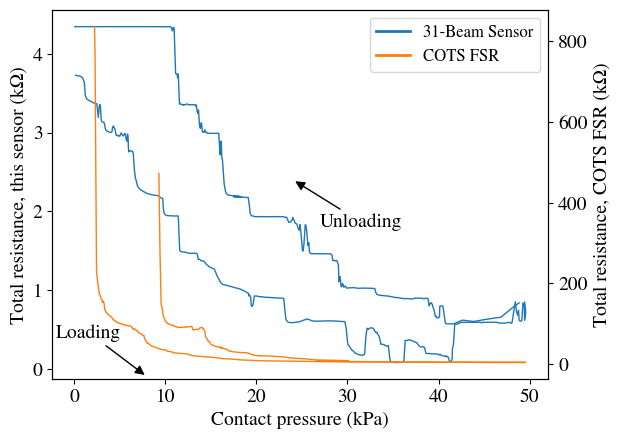

In [2]:
mpl.rcParams['font.size']        = 14
mpl.rcParams['font.family']      = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'

fig, ax = plt.subplots()
axes    = [ax, ax.twinx()]
# bx      = inset_axes(ax, width='40%', height='40%', bbox_to_anchor=(0.06, 0, 1, 1), bbox_transform=ax.transAxes)
lines   = []

# Draw experiment image
# bx.imshow(plt.imread('inset (unsure if same sensor!).png'))
# bx.set_xticks([])
# bx.set_yticks([])

# Plot R/P
for (cycle, loading), gf in data[0].dfdq.dropna().groupby(['Cycle', 'Loading']):
    if cycle == 2:
        plot = axes[0].plot(gf.Pressure, gf.Resistance, lw=1, color=palette[0], label='31-Beam Sensor')
        if loading:
            lines += plot

# Plot COTS FSR R/P
for (cycle, loading), gf in data[1].dfdq.dropna().groupby(['Cycle', 'Loading']):
    if cycle == 2:
        plot = axes[1].plot(gf.Pressure, gf.Resistance, lw=1, color=palette[1], label='COTS FSR')
        if loading:
            lines += plot

# Draw loading/unloading arrows
axes[0].annotate('Loading', xytext=(-2, 0.4), xy=(8, -0.1), arrowprops=dict(arrowstyle='-|>', color='black'))
axes[0].annotate('Unloading', xytext=(27, 1.8), xy=(24, 2.4), arrowprops=dict(arrowstyle='-|>', color='black'))

# Style axes
axes[0].set_xlabel('Contact pressure (kPa)')
axes[0].set_ylabel('Total resistance, this sensor (kΩ)')
axes[1].set_ylabel('Total resistance, COTS FSR (kΩ)')

# Style legend
leg = ax.legend(
    lines,
    [l.get_label() for l in lines],
    loc='upper right',
    fontsize=12,
)
for line in leg.get_lines():
    line.set_linewidth(2)

plt.savefig('plot.png', dpi=600, bbox_inches='tight')
plt.show()